In [1]:
from genetic_algorithm import algorithms, selectors, individuals, crossover
from deap import base, creator, tools
import numpy as np
import random

# Definir los parámetros del problema
IND_SIZE = 12  # Número de genes en cada individuo

# Crear los tipos de fitness e individuo en DEAP
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", individuals.truss_like, fitness=creator.FitnessMax)

# Configuración del entorno evolutivo utilizando DEAP
toolbox = base.Toolbox()

# Registro de las funciones
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", lambda: creator.Individual(np.array([[random.choice([0, 1]) for _ in range(IND_SIZE)] for _ in range(2)])))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", lambda ind: ind.evaluate())
toolbox.register("clone", lambda ind: ind.clone())
toolbox.register("mutate", lambda ind: ind.mutate())
toolbox.register("mate", crossover.mix_crossover)
toolbox.register("select", selectors.select_individuals_elitist)

n_pop = 50
pop = toolbox.population(n=n_pop)

hall_of_fame = tools.HallOfFame(1)

# Definir estadísticas
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)


population, logbook = algorithms.ea(pop, toolbox, 100, halloffame= hall_of_fame, stats= stats)

pm:0.0: 100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


Estructura formada por aluminio (azul) y tungsteno (rojo)

Las barras son de 4 y 8 mm de diámetro

bandgap:12.368 kHz


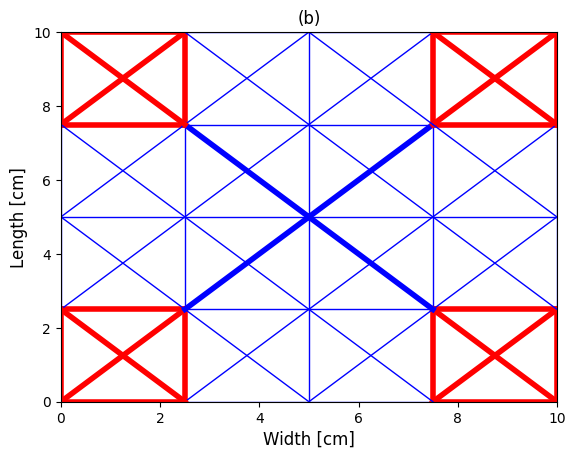

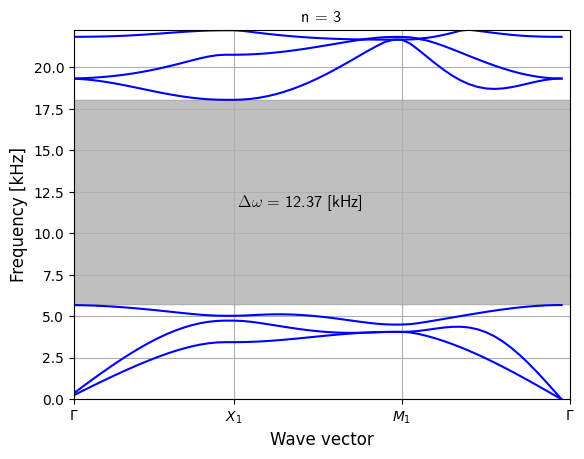

In [2]:
best_individual = hall_of_fame[0]
print(f'bandgap:{best_individual.bandgap:.3f} kHz')
best_individual.plot()


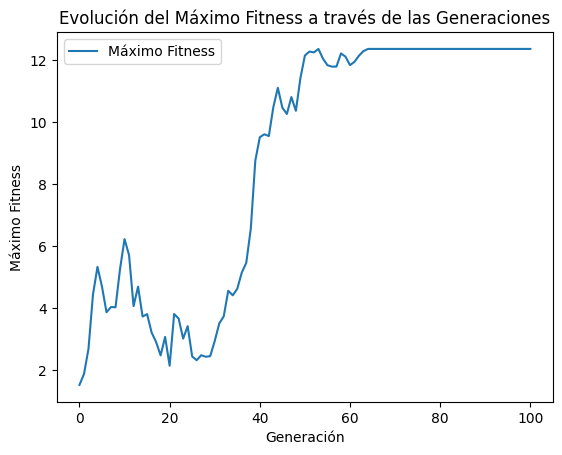

In [3]:
import matplotlib.pyplot as plt
gen, max = logbook.select("gen", "avg")

plt.plot(gen, max, label="Máximo Fitness")
plt.xlabel("Generación")
plt.ylabel("Máximo Fitness")
plt.title("Evolución del Máximo Fitness a través de las Generaciones")
plt.legend()
plt.show()

In [4]:
print(logbook)      

gen	nevals	pm  	avg    	std        	min      	max    
0  	50    	    	1.52977	2.26729    	0.01     	5.51186
1  	44    	5   	1.87705	2.33323    	0.01     	5.51186
2  	44    	5.7 	2.68984	1.94761    	0.01     	5.86383
3  	42    	6   	4.44588	1.58835    	0.86271  	7.87908
4  	44    	5.7 	5.33818	1.18165    	0.0321023	6.49533
5  	47    	10.3	4.69842	1.54382    	1.91074  	8.21186
6  	49    	9.9 	3.87376	1.41842    	1.10113  	6.19362
7  	50    	11.5	4.04299	2.30898    	0.01     	7.60941
8  	50    	14.2	4.03451	1.8612     	1.0242   	7.84013
9  	47    	12.6	5.26948	1.72674    	0.596627 	8.03168
10 	50    	10.9	6.23397	2.16737    	1.64094  	8.31028
11 	50    	16.8	5.71718	2.05787    	0.217104 	8.1539 
12 	50    	13.2	4.07276	1.83419    	1.87498  	8.26354
13 	50    	11.9	4.6992 	2.33891    	0.01     	8.13251
14 	49    	11.1	3.73616	1.80484    	1.48551  	7.21699
15 	49    	13  	3.81338	2.08645    	0.0684376	6.52445
16 	50    	16  	3.22241	1.47377    	0.01     	5.41186
17 	49    	16.2	2.91466	1.58